In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import shutil
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2, l1, l1_l2
import os
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 

np.random.seed(1337)

In [2]:
import h5py

train_file = 'MA0035_4_s5000_train.h5'
test_file = 'MA0035_4_s5000_test.h5'

h5_train = h5py.File(train_file, 'r')
h5_test = h5py.File(test_file, 'r')

train_data = h5_train['data'][:90000]
train_binlabels = h5_train['binlabels'][:90000]

val_data = h5_train['data'][-10000:]
val_binlabels = h5_train['binlabels'][-10000:]

test_data = h5_test['data'][:]
test_binlabels = h5_test['binlabels'][:]

train_data = tf.cast(train_data, dtype=tf.float32)
train_labels = tf.cast(train_binlabels, dtype=tf.float32)

In [3]:
print(train_data.shape)
print(train_data[0])

train_data_T = np.transpose(train_data, axes=(0, 2, 1))
print(train_data_T.shape)
print(train_data_T[0])

(90000, 4, 1000)
tf.Tensor(
[[0. 0. 0. ... 1. 0. 1.]
 [1. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]], shape=(4, 1000), dtype=float32)
(90000, 1000, 4)
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


In [4]:
print(test_data.shape)
test_data_T = np.transpose(test_data, axes=(0, 2, 1))
print(test_data_T.shape)

(10000, 4, 1000)
(10000, 1000, 4)


In [5]:
print(val_data.shape)
val_data_T = np.transpose(val_data, axes=(0, 2, 1))
print(val_data_T.shape)

(10000, 4, 1000)
(10000, 1000, 4)


In [6]:
def train_model(hyperparameters, log_dir):
    board_log = log_dir + '/board'
    hparams_log = log_dir + '/hparams.json'

    my_callbacks = [
        TensorBoard(log_dir=board_log),
        EarlyStopping('val_loss', patience=40)
    ]

    with open(hparams_log, 'w') as hparam_file:
        json.dump(hyperparameters, hparam_file)

    model = tf.keras.models.Sequential(
        [
            Flatten(input_shape=(1000, 4)),
            Dense(10000, activation='relu'),
            Dropout(0.7),
            Dense(10000, activation='relu'),
            Dropout(0.7),
            Dense(1, activation=tf.keras.activations.sigmoid)
        ]
    )

    with tf.device('/GPU:0'):
        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=hyperparameters['learning_rate']),
            loss = tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.AUC(name='auc'), 'accuracy'],
        )

        history = model.fit(train_data_T, train_binlabels,
                epochs=hyperparameters['epochs'], 
                validation_data=(val_data_T, val_binlabels),
                batch_size=hyperparameters['batch_size'],
                callbacks=my_callbacks,
                shuffle=True)

    return model, history

In [7]:
def plot_and_save_roc(false_positive_rate, true_positive_rate, roc_auc, log_dir):
    roc = plt.figure(0)

    plt.plot(false_positive_rate, true_positive_rate, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

    plt.savefig(log_dir + '/roc.pdf')
    pickle.dump(roc, open((log_dir + '/pickle/roc.fig.pickle'), 'wb'))

In [8]:
def plot_and_save_loss(history, log_dir):
    loss = plt.figure(1)
    history_loss = history.history['loss']
    history_val_loss = history.history['val_loss']
    epochs = range(len(history_loss))

    plt.plot(epochs, history_loss, 'ko', label='Training loss')
    plt.plot(epochs, history_val_loss, 'b', label='Validation loss')
    plt.ylim([0.0, 1.5])
    plt.title('Training and validation loss')
    plt.legend()

    plt.savefig(log_dir + '/loss.pdf')
    pickle.dump(loss, open((log_dir + '/pickle/loss.fig.pickle'), 'wb'))

In [9]:
def plot_and_save_auc(history, log_dir):
    auc = plt.figure(2)

    history_auc = history.history['auc']
    history_val_auc = history.history['val_auc']
    epochs = range(len(history_auc))

    plt.plot(epochs, history_auc, 'ko', label='Training auc')
    plt.plot(epochs, history_val_auc, 'b', label='Validation auc')
    plt.title('Training and validation auc')
    plt.ylim(0.46, 1.0)
    plt.legend()

    plt.savefig(log_dir + '/auc.pdf')
    pickle.dump(auc, open((log_dir + '/pickle/auc.fig.pickle'), 'wb'))

Epoch 1/300
704/704 [==============================] - 39s 54ms/step - loss: 0.7683 - auc: 0.5010 - accuracy: 0.5018 - val_loss: 0.6955 - val_auc: 0.5039 - val_accuracy: 0.5030
Epoch 2/300
704/704 [==============================] - 38s 53ms/step - loss: 0.7470 - auc: 0.5077 - accuracy: 0.5049 - val_loss: 0.6952 - val_auc: 0.5092 - val_accuracy: 0.5065
Epoch 3/300
704/704 [==============================] - 35s 49ms/step - loss: 0.7318 - auc: 0.5170 - accuracy: 0.5118 - val_loss: 0.6949 - val_auc: 0.5148 - val_accuracy: 0.5075
Epoch 4/300
704/704 [==============================] - 36s 51ms/step - loss: 0.7228 - auc: 0.5238 - accuracy: 0.5191 - val_loss: 0.6935 - val_auc: 0.5137 - val_accuracy: 0.5121
Epoch 5/300
704/704 [==============================] - 38s 53ms/step - loss: 0.7151 - auc: 0.5294 - accuracy: 0.5219 - val_loss: 0.6935 - val_auc: 0.5144 - val_accuracy: 0.5054
Epoch 6/300
704/704 [==============================] - 38s 54ms/step - loss: 0.7101 - auc: 0.5345 - accuracy: 0.525

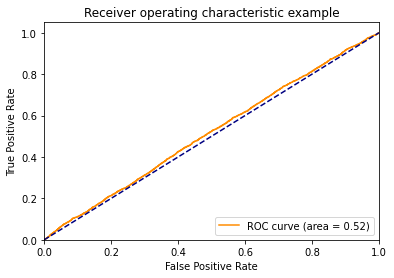

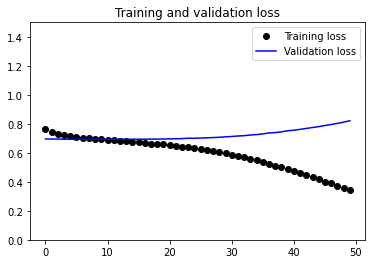

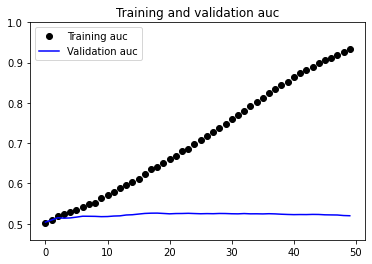

INFO:tensorflow:Assets written to: ./logs/1_layer_test/:10000/model/assets


In [10]:
L0_DROPOUT_RATES = [0.5]
# L0_DROPOUT_RATES = [0.7]
# L1_DROPOUT_RATES = [0.0]
# L2_DROPOUT_RATES = [0.0]
# L1_HIDDEN_UNITS = [16]
# L2_HIDDEN_UNITS = [128]
BATCH_SIZE = [32, 64, 128, 254, 512, 1024]
# LEARNING_RATE = [0.000009]
LEARNING_RATE = [0.000003]

# for l1_hidden_units in L1_HIDDEN_UNITS:
#     for learning_rate in LEARNING_RATE:
for l0_dropout_rate in L0_DROPOUT_RATES:
#             for l1_dropout_rate in L1_DROPOUT_RATES:
    log_dir = './logs/1_layer_test/:' + '10000'

    try:
        shutil.rmtree(log_dir)
    except OSError as e:
        print(e)

    try:
        os.makedirs(log_dir)
        os.makedirs(log_dir + '/pickle')
    except OSError as e:
        print(e)

    hparams = {
        'l0_dropout_rate': l0_dropout_rate,
        'learning_rate': LEARNING_RATE[0],
        'batch_size': BATCH_SIZE[2],
        'epochs': 300,
    }

    model, history = train_model(hparams, log_dir)

    loss, acc, auc = model.evaluate(test_data_T, test_binlabels)
    yhat = model.predict(test_data_T)
    fpr, tpr, _ = roc_curve(test_binlabels, yhat)
    roc_auc = roc_auc_score(test_binlabels, yhat)

    plot_and_save_roc(fpr, tpr, roc_auc, log_dir)
    plot_and_save_loss(history, log_dir)
    plot_and_save_auc(history, log_dir)

    plt.show()
    model.save(log_dir + '/model')